# Image search in e-commerce

This use-case notebook shows semantic search in fashion images. 

In e-commerce, being able to serve user queries with the most relevant results is of utmost importance. Users predominantly use text to describe what they would like and that poses a problem e-commerce websites face: products generally lack extensive textual information. However, there is no better way to describe a product than an image. Luckily, researchers also realised that, and came up with multi-modal Vision Transformers that embed text and images in the same space, thereby making us able to search with text in images of products. Namely, searching for an "elegant dress" does not require the description to contain anything similar to return the actual elegant dresses.

To demonstrate that, we are going to perform search in a fashion dataset consinsting of images with short descriptions. We will be able to search:
- with text in the descriptions,
- with text in the images,
- with an image in the images

or we can combine these in the following ways:
- search with the same or different text in the descriptions and the images
- search with text in the descriptions, and with images in the images

we will show that multi-modal search in the text embedding AND the image embedding space is the best approach to get the most relevant results.

In [1]:
%pip install superlinked==12.7.0
%pip install datasets
%pip install matplotlib
%pip install open-clip-torch

In [2]:
import logging
from io import BytesIO
import matplotlib.pyplot as plt
import open_clip
import pandas as pd
import PIL.Image
import requests
import torch

from datasets import load_dataset
from beartype.typing import Any, Hashable
from tqdm import tqdm
from requests import RequestException

from superlinked.framework.common.schema.id_schema_object import IdField
from superlinked.framework.common.schema.schema import schema
from superlinked.framework.common.schema.schema_object import FloatList, String
from superlinked.framework.dsl.executor.in_memory.in_memory_executor import (
    InMemoryExecutor,
)
from superlinked.framework.dsl.index.index import Index
from superlinked.framework.dsl.source.in_memory_source import InMemorySource
from superlinked.framework.dsl.space.custom_space import (
    CustomSpace,
)
from superlinked.framework.dsl.space.text_similarity_space import TextSimilaritySpace
from superlinked.framework.dsl.query.param import Param
from superlinked.framework.dsl.query.query import Query

logging.basicConfig()
logging.getLogger().setLevel(logging.WARNING)

DATASET_ID: str = "tomytjandra/h-and-m-fashion-caption"
VIT_MODEL_ID: str = "hf-hub:laion/CLIP-ViT-H-14-laion2B-s32B-b79K"
WEIGHTS_URL: str = (
    "https://storage.googleapis.com/superlinked-amazon-esci/finetuned_clip.pt"
)
WATCH_IMAGE_URL: str = (
    "https://storage.googleapis.com/superlinked-notebook-image-search/watch.jpg"
)
NUM_SAMPLES = 2000
SEED = 42
LIMIT = 4

## Create Image embeddings

Let's use a state-of-the-art OpenCLIP model to embed a fashion product dataset! The dataset we are going to use are images and captions of H&M products.

### Load model

In [3]:
%%capture
model, preprocess_train, preprocess_val = open_clip.create_model_and_transforms(
    VIT_MODEL_ID
)
tokenizer = open_clip.get_tokenizer(VIT_MODEL_ID)

### Load data

In [4]:
# depending on your internet connection, downloading the dataset for the first time may take several minutes.
fashion_dataset = load_dataset(DATASET_ID)
fashion_sample_dataset = (
    fashion_dataset["train"].shuffle(seed=SEED).select(range(NUM_SAMPLES))
)

### Organize metadata

In [5]:
fashion_sample_dataset[0]

{'text': 'solid black blouse in woven fabric with a collar and buttons down the front gathers at the shoulders long sleeves with buttoned cuffs and a rounded hem slightly longer at the back',
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1166x1750>}

In [6]:
fashion_json_data = [item for i, item in enumerate(fashion_sample_dataset)]
for i, item in enumerate(fashion_json_data):
    fashion_json_data[i]["id"] = i
fashion_df = pd.DataFrame(fashion_json_data)
fashion_df["description"] = fashion_df["text"]
fashion_df.head()

,text,image,id,description
0,solid black blouse in woven fabric with a coll...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,0,solid black blouse in woven fabric with a coll...
1,solid dark grey coat in soft boucle made from ...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,1,solid dark grey coat in soft boucle made from ...
2,solid dark red trousers in ribbed velour with ...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,2,solid dark red trousers in ribbed velour with ...
3,solid black calf-length straight-style tunic i...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,3,solid black calf-length straight-style tunic i...
4,all over pattern black long-sleeved blouse in ...,<PIL.JpegImagePlugin.JpegImageFile image mode=...,4,all over pattern black long-sleeved blouse in ...


### Quickly try the model out

Let's explore multi-modality in the shared embedding space by finding the textual label whose embedding is closest to that of an image of a black shirt.

Here is a sample picture of a shirt:

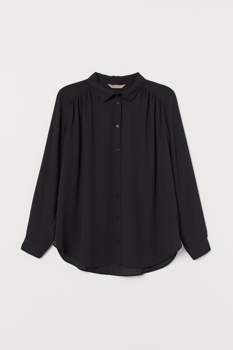

In [7]:
sample_picture = fashion_sample_dataset[0]["image"]
sample_picture.resize([int(size_dim / 5) for size_dim in sample_picture.size])

Now, let's demonstrate that text and image representations are closely aligned in the same embedding space when they refer to the same concept.

In [8]:
image = preprocess_val(fashion_dataset["train"][0]["image"]).unsqueeze(0)
raw_text = ["a hat", "a shirt", "watch", "shoes"]
text = tokenizer(raw_text)

with torch.no_grad():
    image_features = model.encode_image(image)
    text_features = model.encode_text(text)
    text_probs = (image_features @ text_features.T).softmax(dim=-1)

label_prob_data = pd.DataFrame.from_dict(
    {
        label: round(text_prob, 4)
        for label, text_prob in zip(raw_text, text_probs[0].tolist())
    },
    orient="index",
    columns=["similarity"],
)

print("Label probs:")
label_prob_data

Label probs:


,similarity
a hat,0.0
a shirt,1.0
watch,0.0
shoes,0.0


The most probable label is "shirt" by a unambiguous margin.

### Embed our dataset

In [9]:
# helper to embed text with the Vision Transformer
def encode_text(
    encoding_model: Any, text_to_encode: str, tokenizer_to_use: Any
) -> list[float]:
    text_tokenized = tokenizer_to_use(text_to_encode)
    text_feature_encoding = encoding_model.encode_text(text_tokenized)
    text_feature_encoding /= text_feature_encoding.norm(dim=-1, keepdim=True)
    return text_feature_encoding[0].tolist()


# helper to embed images with the Vision Transformer
def encode_image(encoding_model: Any, image_to_process: Any) -> list[float]:
    image_to_process = preprocess_val(image_to_process).unsqueeze(0)
    image_feature_encoding = encoding_model.encode_image(image_to_process)
    image_feature_encoding /= image_feature_encoding.norm(dim=-1, keepdim=True)
    return image_feature_encoding[0].tolist()

In [10]:
image_embeddings = []
with torch.no_grad():
    for fashion_item in tqdm(fashion_sample_dataset):
        image_features = encode_image(model, fashion_item["image"])
        image_embeddings.append(image_features)

100%|██████████| 2000/2000 [10:24<00:00,  3.20it/s]


In [11]:
# store data in json to easily ingest to superlinked later
fashion_df["image_embedding"] = image_embeddings
json_data: list[dict[Hashable, Any]] = fashion_df.to_dict(orient="records")

## Superlinked setup

Now let's set Superlinked up to perform multi-modal vector search on our dataset!

In [13]:
@schema
class Image:
    id: IdField
    image_embedding: FloatList  # we need to supply image embedding vectors using this SchemaFieldType
    description: String


image = Image()

In [14]:
# CustomSpace enables ingesting any particular vector embedding
image_embedding_space = CustomSpace(vector=image.image_embedding, length=1024)
# Embed descriptions using a text embedding model
description_space = TextSimilaritySpace(
    text=image.description, model="Alibaba-NLP/gte-large-en-v1.5"
)

# construct an index
composite_index = Index([image_embedding_space, description_space])

In [15]:
source: InMemorySource = InMemorySource(image)
executor = InMemoryExecutor(sources=[source], indices=[composite_index])
app = executor.run()

In [16]:
source.put(json_data)

In [17]:
DUMMY_IMAGE = [0] * 1024
DUMMY_TEXT = ""

combined_query = (
    Query(
        composite_index,
        weights={
            description_space: Param("description_weight"),
            image_embedding_space: Param("image_embedding_weight"),
        },
    )
    .find(image)
    .similar(description_space, Param("text_search"))
    .similar(image_embedding_space, Param("image_search"))
    .limit(LIMIT)
)

## Search images

In [18]:
# helper functions to plot image results
def plot_result_pictures(result_df: pd.DataFrame) -> None:
    ax = plt.subplots(1, LIMIT, figsize=(LIMIT * 3, 2))[1]
    ax = ax.flatten()
    result_num = 1
    for result_id, ax_ in zip(result_df["id"].tolist(), ax):
        ax_.imshow(fashion_sample_dataset["image"][int(result_id)])
        ax_.set_title(f"Result {result_num}", fontsize=16)
        result_num += 1
        ax_.set_axis_off()


def plot_result_picture_comparison(result_df_by_name: dict[str, pd.DataFrame]) -> None:
    num_results = len(result_df_by_name.keys())
    fig = plt.figure(constrained_layout=True, figsize=(3 * num_results, 5 * LIMIT / 2))
    fig.suptitle("Result comparison", fontsize=16)

    # create 3x1 subfigs
    subfigs = fig.subfigures(nrows=num_results, ncols=1)
    for subfig, (label, result_df) in zip(subfigs, result_df_by_name.items()):
        subfig.suptitle(f"{label}", fontsize=12)

        # create 1x3 subplots per subfig
        axs = subfig.subplots(nrows=1, ncols=LIMIT)
        for col, ax in enumerate(axs):
            ax.imshow(fashion_sample_dataset["image"][int(result_df["id"].iloc[col])])
            ax.set_title(f"Result {col+1}", fontsize=10)
            ax.set_axis_off()

### Search with text in the description field

Let's first try searching only with text in the descriptions of the products. This approach requires extensive descriptions to work well.

In [19]:
TEXT_TO_SEARCH_WITH = "women high waist black slim fit jeans"

In [20]:
result_text = app.query(
    combined_query,
    description_weight=1,
    image_embedding_weight=0,
    text_search=TEXT_TO_SEARCH_WITH,
    image_search=DUMMY_IMAGE,
)

result_text_df = result_text.to_pandas()
result_text_df

,image_embedding,description,id,similarity_score,rank
0,"[-0.046298228204250336, -0.006646903231739998,...",solid black high-waisted jersey leggings with ...,85,0.544675,0
1,"[-0.004832603503018618, -0.009484757669270039,...",denim black 5-pocket slim-fit jeans in stretch...,778,0.544519,1
2,"[-0.042178522795438766, -0.014080953784286976,...",denim black high-waisted jeans in washed stret...,193,0.541372,2
3,"[-0.0531022772192955, -0.036862049251794815, -...",solid black slim-fit trousers in stretch cotto...,597,0.539680,3


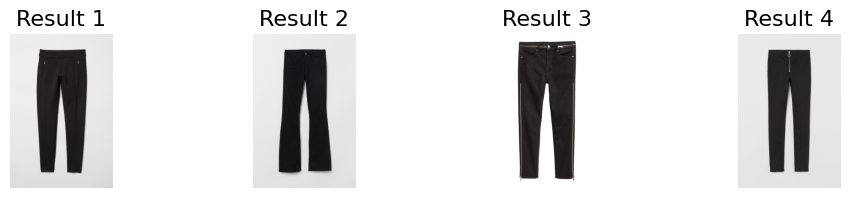

In [21]:
plot_result_pictures(result_text_df)

It can be spotted that the 2nd result has a wide fit at the ankle, and at least the 1st result is not particularly high-waist. Matching solely on text embeddings produces false positive results - among right ones.

### Search with text in the image space

In [22]:
result_text_in_images = app.query(
    combined_query,
    description_weight=0,
    image_embedding_weight=1,
    text_search=DUMMY_TEXT,
    image_search=encode_text(model, TEXT_TO_SEARCH_WITH, tokenizer),
)

result_text_in_images_df = result_text_in_images.to_pandas()
result_text_in_images_df

,image_embedding,description,id,similarity_score,rank
0,"[-0.00811561569571495, -0.034364648163318634, ...",denim black 5-pocket jeans in washed stretch d...,1504,0.216618,0
1,"[-0.028250128030776978, -0.027010688558220863,...",solid black jeggings in washed denim with a st...,1855,0.214753,1
2,"[-0.018405918031930923, -0.017975743860006332,...",solid black 5-pocket jeans in washed stretch d...,1497,0.206442,2
3,"[-0.04388360679149628, -0.027725016698241234, ...",denim black 5-pocket low-rise ankle-length jea...,577,0.197584,3


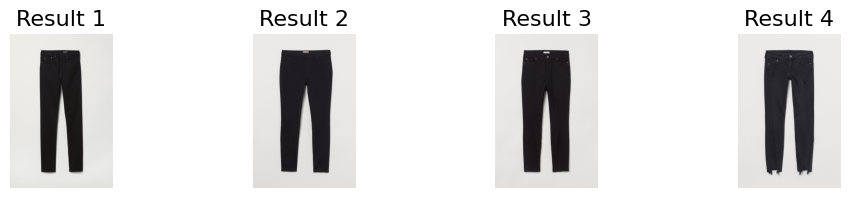

In [23]:
plot_result_pictures(result_text_in_images_df)

Searching with text in the image space definitely improves the results, but there is a false positve present in the 4th position that has low-waist design.

### Search with image in image space

It is also possible to search with a reference image in the image embedding space.

In [24]:
# helper function to read an image from a public gcs bucket
def open_image_from_public_gcs(public_url: str) -> PIL.Image.Image:
    # Construct the public URL for the GCS object
    public_url = WATCH_IMAGE_URL

    # Fetch the image using the public URL
    response = requests.get(public_url, timeout=5)

    # Ensure the request was successful
    if response.status_code == 200:
        # Open the image with PIL using the downloaded bytes
        downloaded_image = PIL.Image.open(BytesIO(response.content))
        return downloaded_image
    raise RequestException(
        f"Failed to fetch image. Status code: {response.status_code}",
    )

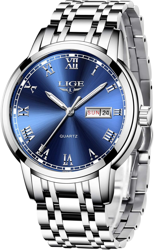

In [25]:
watch_image = open_image_from_public_gcs(WATCH_IMAGE_URL)
width, height = watch_image.size
watch_image.resize((int(width / 6), int(height / 6)))

In [26]:
watch_embedding = encode_image(model, watch_image)

result_image = app.query(
    combined_query,
    description_weight=0,
    image_embedding_weight=1,
    text_search=DUMMY_TEXT,
    image_search=watch_embedding,
    limit=4,
)

result_image_df = result_image.to_pandas()
result_image_df

,image_embedding,description,id,similarity_score,rank
0,"[-0.028569484129548073, -0.05401850864291191, ...",stripe light blue shirt in a textured premium ...,1220,0.278843,0
1,"[-0.022232363000512123, -0.003910871222615242,...",denim blue 5-pocket jeans in washed cotton den...,627,0.271074,1
2,"[0.005834984127432108, -0.046916663646698, -0....",denim light blue 5-pocket ankle-length jeans i...,1944,0.270014,2
3,"[-0.004724388476461172, -0.03285118192434311, ...",denim dark blue denim shirt in a straight gent...,1534,0.267541,3


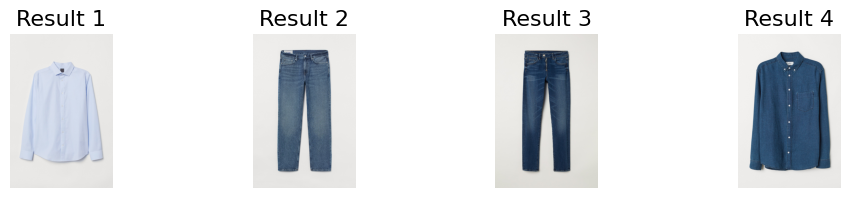

In [27]:
plot_result_pictures(result_image_df)

The results are indeed quite fitting in terms of style with the reference image - or we could say it swayed the results towards silver and blue colors. Of course the dataset only contains clothes, so no watches are popping up.

### Search with text in the description space and image in the image space

In [28]:
result_text_image_combined = app.query(
    combined_query,
    description_weight=1,
    image_embedding_weight=1,
    text_search=TEXT_TO_SEARCH_WITH,
    image_search=watch_embedding,
    limit=4,
)

result_text_image_combined_df = result_text_image_combined.to_pandas()
result_text_image_combined_df

,image_embedding,description,id,similarity_score,rank
0,"[-0.0017915868666023016, -0.04217833653092384,...",denim black 5-pocket low-rise jeans in stretch...,1523,0.545856,0
1,"[-0.014611276797950268, -0.04802258685231209, ...",solid black calf-length culottes in a crepe we...,1569,0.537238,1
2,"[-0.01839958317577839, -0.020392779260873795, ...",solid black trousers in soft sweatshirt fabric...,777,0.537090,2
3,"[-0.018405918031930923, -0.017975743860006332,...",solid black 5-pocket jeans in washed stretch d...,1497,0.536977,3


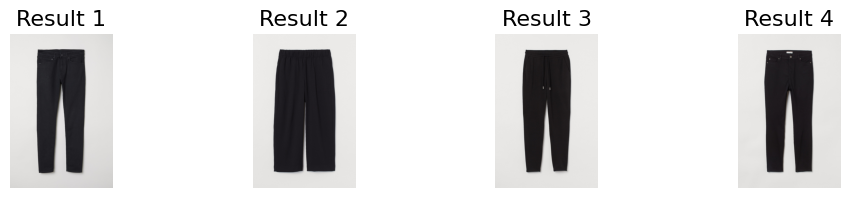

In [29]:
plot_result_pictures(result_text_image_combined_df)

Using a reference image and text to search in descriptions seems to take little effect - there are much better hits for the description than to the reference watch, hence the image can sway the results to a quite small extent.

### Search with text in the description space and image in the image space

In [30]:
result_text_image = app.query(
    combined_query,
    description_weight=1,
    image_embedding_weight=2,
    text_search=TEXT_TO_SEARCH_WITH,
    image_search=encode_text(model, TEXT_TO_SEARCH_WITH, tokenizer),
    limit=4,
)

result_text_image_df = result_text_image.to_pandas()
result_text_image_df

,image_embedding,description,id,similarity_score,rank
0,"[-0.018405918031930923, -0.017975743860006332,...",solid black 5-pocket jeans in washed stretch d...,1497,0.422926,0
1,"[-0.028250128030776978, -0.027010688558220863,...",solid black jeggings in washed denim with a st...,1855,0.419495,1
2,"[-0.00811561569571495, -0.034364648163318634, ...",denim black 5-pocket jeans in washed stretch d...,1504,0.418249,2
3,"[-0.023723429068922997, -0.014120080508291721,...",denim black super skinny jeans in washed stret...,50,0.413131,3


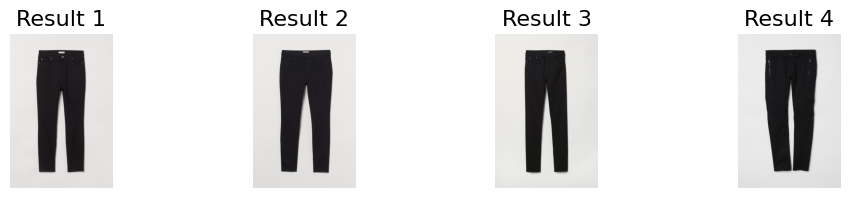

In [31]:
plot_result_pictures(result_text_image_df)

The utterly powerful approach is to search with the same text in the description and in the image embedding space - ensuring hits on both data sources. Resulting in the most pure result set of high-waist, black, slim fit women's jeans.

## Result comparison

Lets compare the most promising results to the simple text search for black, slim-fit and high-waist women's jeans. Also take it into account that users rarely search with a reference image, they rather use text - therefore the compared result sets are all relevant in a real-world scenario.

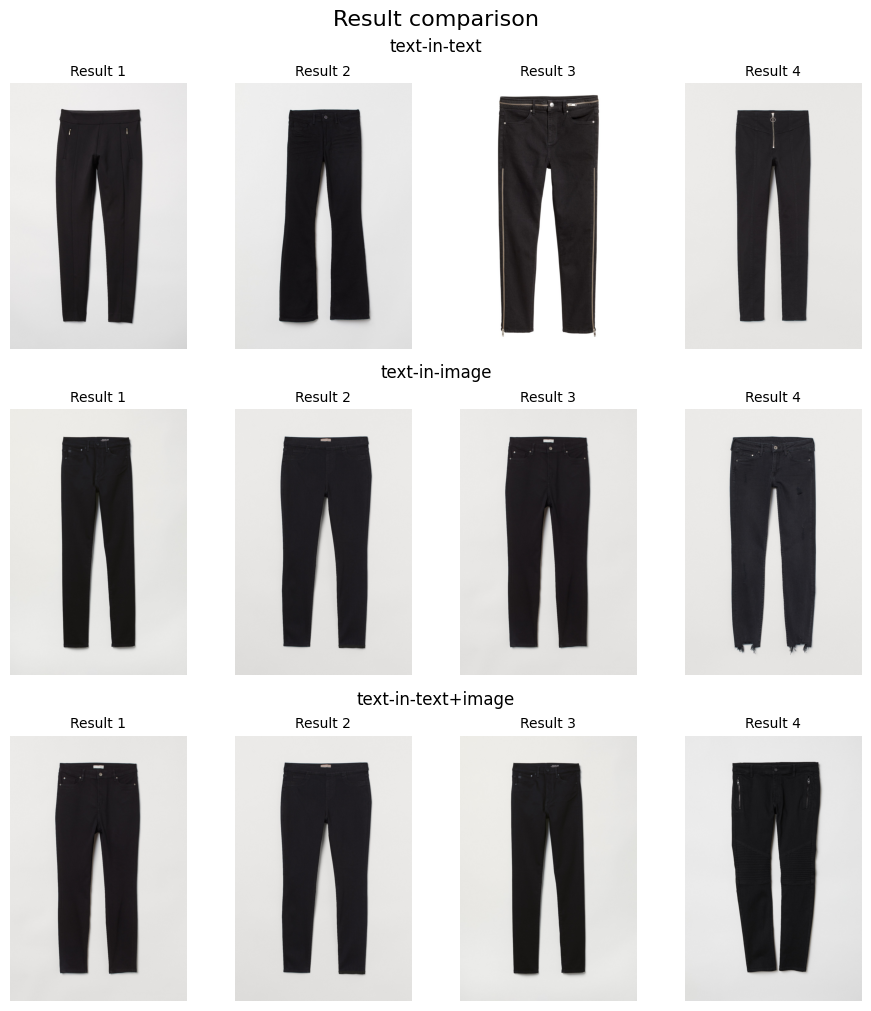

In [32]:
result_df_map = {
    "text-in-text": result_text_df,
    "text-in-image": result_text_in_images_df,
    "text-in-text+image": result_text_image_df,
}

plot_result_picture_comparison(result_df_map)

## Summary

1. `text-in-text` search is suboptimal due to producing false positives among relevant hits due to spurious semantic similarity. The first result is not high-waist for instance.
1. `text-in-image` search creates a substantial improvement but arguably shows a low-waist model at `Result 4`.
1. `text-in-text+image` search improves upon the `text-in-image` by removing the low-waist jeans through cross-checking its description. All the results are high-waist and slim-fit, thereby arising as the most reliable approach.

In conclusion, utilizing multi-modal vector search improves upon using even the most sophisticated, in itself multi-modal image+text embedding models. The description and the image of a product can contain unique information, therefore utilising both is essential for creating high performing product search - or image search in general.